# Analyzing Atrato's Portuguese Migrants 🇵🇹

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import plotly.graph_objects as gp
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('atrato-data.xlsx')
df = df[df.nationality=="Portuguese"].reset_index(drop=True)

## Demographics

In [3]:
display("Total of Portuguese migrants:{}".format(len(df)))

'Total of Portuguese migrants:199'

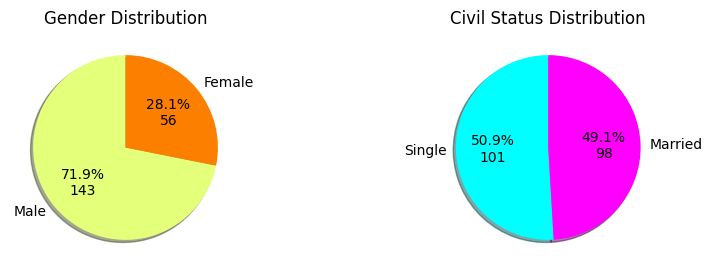

In [4]:
fig, axes = plt.subplots(ncols=2)

gender = df["gender"].to_frame("Gender").value_counts().to_frame("Total")
gender.plot.pie(title="Gender Distribution", figsize=(10,3), cmap="Wistia",
                autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(df)*prct_value/100)),
                shadow=True, startangle=90, labels=["Male","Female"], y='Total',ylabel='',
                ax=axes[0]).get_legend().remove()

civil_status = df["civil-status"].to_frame("Civil Status").value_counts().to_frame("Total")
civil_status.plot.pie(title="Civil Status Distribution", figsize=(10,3), cmap="cool",
                      autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(df)*prct_value/100)),
                      shadow=True, startangle=90, labels=["Single","Married"], y='Total', ylabel='',
                      ax=axes[1]).get_legend().remove()

In [5]:
years= df['years'].dropna().astype(int)
months = df['months'].dropna().astype(int)
no_age = df[df['years'].isna() & df['months'].isna()]
print("Total of passengers with age:", len(years)+len(months))
print("Total of passengers without age:", len(no_age))

Total of passengers with age: 194
Total of passengers without age: 5


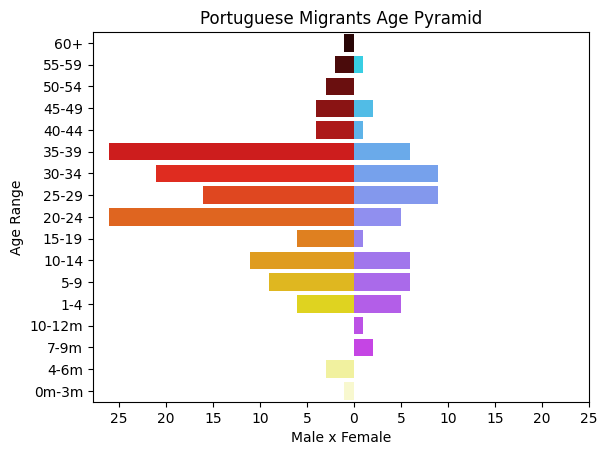

In [6]:
pyramid = pd.DataFrame()

male_infants = df[df.gender=="M"].months.dropna().astype(int).value_counts(bins=[0,3,6,9,12])\
                                 .sort_index(ascending=False)
female_infants = df[df.gender=="F"].months.dropna().astype(int).value_counts(bins=[0,3,6,9,12])\
                                   .sort_index(ascending=False)
male_general = df[df.gender=="M"].years.dropna().astype(int)\
                         .value_counts(bins=[0,4,9,14,19,24,29,34,39,44,49,54,59,80]).sort_index(ascending=False)
female_general = df[df.gender=="F"].years.dropna().astype(int)\
                         .value_counts(bins=[0,4,9,14,19,24,29,34,39,44,49,54,59,80]).sort_index(ascending=False)

pyramid["male"] = pd.concat([male_general,male_infants])
pyramid["female"] = pd.concat([female_general,female_infants])
pyramid["male"] = pyramid["male"] * -1
pyramid["age"] = ['60+','55-59', '50-54', '45-49', '40-44','35-39','30-34', '25-29',
                  '20-24', '15-19', '10-14', '5-9', '1-4','10-12m','7-9m','4-6m','0m-3m']

pyramid = pyramid.reset_index(drop=True)
male_axis = sns.barplot(x='male', y='age', data=pyramid, order=pyramid["age"], palette="hot");
female_axis = sns.barplot(x='female', y='age', data=pyramid, order=pyramid["age"], palette="cool");
plt.title("Portuguese Migrants Age Pyramid");
plt.xticks(ticks=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25],
           labels=['25', '20', '15', '10', '5','0', '5', '10', '15', '20', '25']);
plt.xlabel("Male x Female");
plt.ylabel("Age Range");

## Travel

In [7]:
distritos_geodata = gpd.read_file("distritos.geojson")
distritos_data = pd.read_csv("distritos_passaportes.csv", converters={"DI": str})

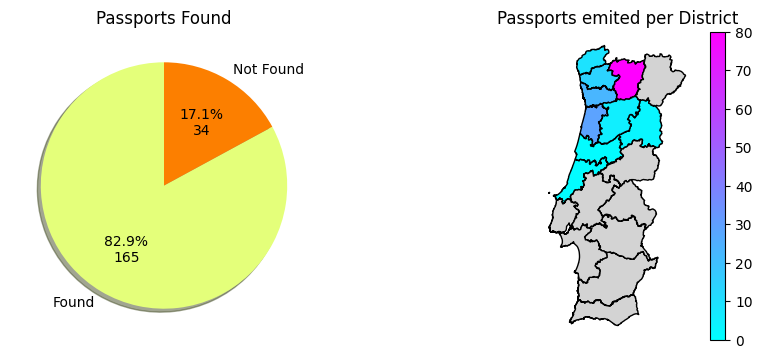

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
DI,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18
distrito,Aveiro,Beja,Braga,Bragança,Castelo Branco,Coimbra,Évora,Faro,Guarda,Leria,Lisboa,Portalegre,Porto,Santarém,Setúbal,Viana do Castelo,Vila Real,Viseu
passaportes,29,<NA>,14,<NA>,<NA>,1,<NA>,<NA>,3,1,<NA>,<NA>,23,<NA>,<NA>,9,81,5


In [8]:
fig, axes = plt.subplots(ncols=2)

passport = df["found_passport"].to_frame("Passports Found").value_counts().to_frame("Total")
passport.plot.pie(title="Passports Found", figsize=(10,4), cmap="Wistia",ax=axes[0], ylabel='',
                autopct=(lambda prct_value: "{:.1f}%\n{:.0f}".format(prct_value,len(df)*prct_value/100)),
                shadow=True, startangle=90, labels=["Found","Not Found"], y="Total").get_legend().remove()
plt.title("Passports emited per District")
distritos_map = distritos_geodata.merge(distritos_data, on="DI")
distritos_map = distritos_map[["DI","distrito", "geometry", "passaportes"]]
distritos_map.plot(column = "passaportes",cmap="cool",figsize=(15,4), vmax=80, vmin=0, ax=axes[1],
                   legend=True, edgecolor="black", missing_kwds= dict(color = "lightgrey",))
plt.axis("off")
plt.show()

dd = distritos_data.copy()
dd["passaportes"]=dd["passaportes"].astype("Int64")
display(dd.T)